In [60]:
# First we obtain data to compute the log D/P ratio
# The FRED MD dataset is a good (free) source of data
# See 
# Bai, Jushan and Ng, Serena (2002), "Determining the number of factors in approximate factor models".
# McCracken, Michael W. and Ng, Serena (2015), "FRED-MD and FRED-QD: Monthly and Quarterly Databases for Macroeconomic Research".
# Bai, Jushan and Ng, Serena (2019), "Matrix Completion, Counterfactuals, and Factor Analysis of Missing Data".
	

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
url ="https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv"
df = pd.read_csv(url, index_col=0, parse_dates=True)
# keep S&P div yield and S&P 500
df = df[['S&P div yield', 'S&P 500']]

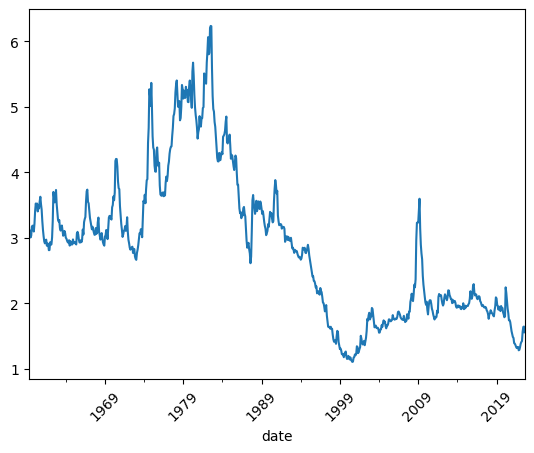

In [67]:
# Transform suggests a transformation of the series given a code, but we stick to the Campbell and Shiller definition
df = df.iloc[1:]
# remove nan
df = df.dropna()

# rename S&P div yield to D/P
# rename S&P 500 to P

df = df.rename(columns={'S&P div yield': 'D/P', 'S&P 500': 'P'})

# D/P is expressed in percentage,
df['D/P'] = df['D/P']

# recover D by multiplying by P (and divide by 100)
df['D'] = df['D/P']*df['P']/100

# compute Delta log D 
df['Delta d'] = np.log(df['D']).diff()
# take logs to D/P 
df['d-p'] = np.log(df['D/P'])
# rename D/P to d-p 

# compute log returns to P
df['p'] = np.log(df['P'])
df['r'] = df['P'].diff()

# plot D/P
df['D/P'].plot()
# rotate axis
plt.xticks(rotation=45);


<AxesSubplot:xlabel='date'>

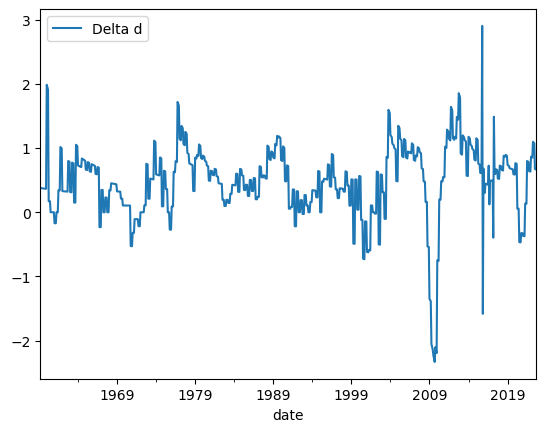

In [65]:
# rename index to date
df.index.name = 'date'
# make index datetime, format is month day year
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')
# plot some of the graphs
df[['Delta d']].plot()


In [74]:
# add two more variables r at t +1 and Delta d at t +1
df['r+1'] = df['r'].shift(-1)
df['Delta d+1'] = df['Delta d'].shift(-1)


In [86]:
# compute forward returns, sum between r today and r 60 months later
tau = 12*6
# first compute cum sums
df['cum_r'] = df['r'].cumsum()
df[f'r+{tau}'] = df['cum_r'].shift(-tau) - df['cum_r']
# remove nan
df = df.dropna()
# regress r+60 on d-p 
import statsmodels.api as sm
X = df['d-p']
y = df[f'r+{tau}']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   r+72   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     221.3
Date:                Sun, 22 Jan 2023   Prob (F-statistic):           5.16e-35
Time:                        17:20:42   Log-Likelihood:                -909.02
No. Observations:                 220   AIC:                             1822.
Df Residuals:                     218   BIC:                             1829.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -112.2511      8.701    -12.900      0.000    -129.401     -95.101
d-p          106.8230      7.181     14.875      0.000      92.670     120.976
==============================================================================
Omnibus:                        7.605   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                4.274
Skew:                          -0.128   Prob(JB):                        0.118
Kurtosis:                       2.367   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='date'>

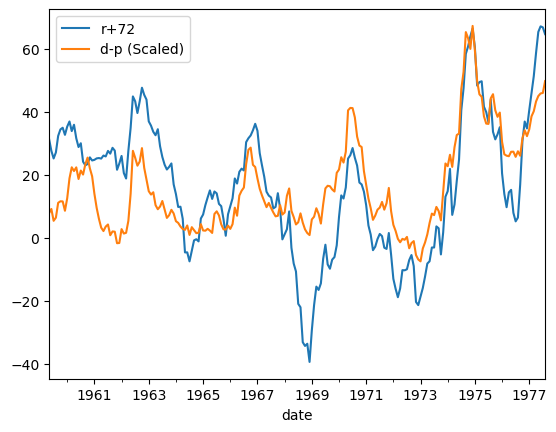

In [88]:
# plot f'r+{tau}' and d-p 
df['d-p (Scaled)'] = df['d-p']*model.params[1]+model.params[0]
df[[f'r+{tau}', 'd-p (Scaled)']].plot()

In [90]:
# Sign restrictions? Regress r+1 on d-p and Delta d+1 on d-p, store the residuals
# regress r+1 on d-p and Delta d+1 on d-p, store the residuals
X = df['d-p']

y = df['r+1'] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
b_r = model.params[1]



                            OLS Regression Results                            
Dep. Variable:                    r+1   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.183
Date:                Sun, 22 Jan 2023   Prob (F-statistic):              0.278
Time:                        17:22:25   Log-Likelihood:                -545.06
No. Observations:                 220   AIC:                             1094.
Df Residuals:                     218   BIC:                             1101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6230      1.664     -0.975      0.3

In [94]:
X = df['d-p']
y = df['Delta d+1']*100
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
b_d = model.params[1]

# what is b_r - b_d ? is not exactly 1, but not crazy far from it
# this is because dividend growth is unpredictable
# b_r - b_d

                            OLS Regression Results                            
Dep. Variable:              Delta d+1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                  0.003154
Date:                Sun, 22 Jan 2023   Prob (F-statistic):              0.955
Time:                        17:43:56   Log-Likelihood:                -136.57
No. Observations:                 220   AIC:                             277.1
Df Residuals:                     218   BIC:                             283.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4062      0.260      1.563      0.1

In [ ]:
# compute rho for long term reg
x_0 = - df['d-p'].mean()
rho = np.exp(x_0)/(np.exp(x_0)+1)

T = 100 # number of periods
# compute the weighted sum between r+j and r+T weighted by rho**j

# time index
time_ = np.arange(len(df))
for t in time_:
    lhs = sum([rho**j*df['r+1'].iloc[t+j] for j in range(T)])
